In [2]:
from __future__ import print_function, division
import pandas as pd
import pylab as plt
import os

from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats
import geopandas as gp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
yc1704 = pd.read_csv("yellow_tripdata_2017-04.csv")

treatment area ID : 140 141 262 263

control area ID : 229

In [4]:
df_drop = yc1704[((yc1704['DOLocationID'] == 140)| (yc1704['DOLocationID'] == 141)|(yc1704['DOLocationID'] == 262)|\
         (yc1704['DOLocationID'] == 263))]

df_drop_ctr = yc1704[((yc1704['DOLocationID'] == 229))]

In [5]:
df_drop.reset_index(inplace=True)
df_drop_ctr.reset_index(inplace=True)

In [6]:
df_drop.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,5,1,2017-04-01 00:00:01,2017-04-01 00:07:28,1,2.20,1,N,170,263,1,8.5,0.5,0.5,2.45,0.0,0.3,12.25
1,20,1,2017-04-01 00:00:03,2017-04-01 00:18:44,2,3.60,1,N,164,140,1,15.0,0.5,0.5,3.00,0.0,0.3,19.30
2,22,2,2017-04-01 00:00:03,2017-04-01 00:24:37,5,4.31,1,N,113,141,1,18.5,0.5,0.5,3.96,0.0,0.3,23.76
3,24,1,2017-04-01 00:00:04,2017-04-01 00:20:00,1,5.00,1,N,125,263,1,17.5,0.5,0.5,3.75,0.0,0.3,22.55
4,38,2,2017-04-01 00:00:05,2017-04-01 00:02:22,2,0.53,1,N,141,263,1,4.0,0.5,0.5,1.06,0.0,0.3,6.36


In [7]:
df_drop['dp_time'] = pd.to_datetime(df_drop['tpep_pickup_datetime'])

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
df_drop.columns

Index(['index', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'dp_time'],
      dtype='object')

In [9]:
df_drop.drop(['index', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'payment_type', 'fare_amount', 'extra', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount'], axis=1, inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
df_drop['new_time'] = df_drop['dp_time'].apply(lambda t: t.replace(hour=0, minute=0, second=0))

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
df_drop_ID = df_drop.groupby(['PULocationID']).size().to_frame('pick_count').reset_index()
df_drop = df_drop.groupby(['PULocationID','new_time']).size().to_frame('pick_count').reset_index()

In [12]:
df_drop.head()

,PULocationID,new_time,pick_count
0,4,2017-04-01,36
1,4,2017-04-02,44
2,4,2017-04-03,15
3,4,2017-04-04,14
4,4,2017-04-05,43


In [13]:
df_drop = df_drop[~((df_drop.new_time == '2017-04-29 00:00:00')| (df_drop.new_time == '2017-04-30 00:00:00'))]
df_drop = df_drop[~((df_drop.new_time == '2017-05-01 00:00:00'))]
df_drop = df_drop[~((df_drop.PULocationID == 264)| (df_drop.PULocationID == 265))]
df_drop.shape

(2745, 3)

In [14]:
datelist = pd.date_range('2017-04-01', periods=28, freq='D')

In [15]:
df_drop.reset_index(inplace=True)

In [16]:
arr = np.zeros((263,28), dtype=float)
df_drop['time_index'] = ''
for i in range(len(df_drop)):
    for j in range(len(datelist)):
        if df_drop['new_time'][i] == datelist[j]:
            df_drop['time_index'][i] = j
        else:
            pass

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
for i in range(len(df_drop)):
    arr[df_drop['PULocationID'][i]-1][df_drop['time_index'][i]] = df_drop['pick_count'][i]

In [18]:
arr

array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ..., 
       [   30.,    44.,    36., ...,    41.,    41.,    38.],
       [ 1060.,   792.,   934., ...,  1065.,  1139.,  1152.],
       [ 1879.,  1476.,  1288., ...,  1372.,  1509.,  1598.]])

Text(0,0.5,'rides')

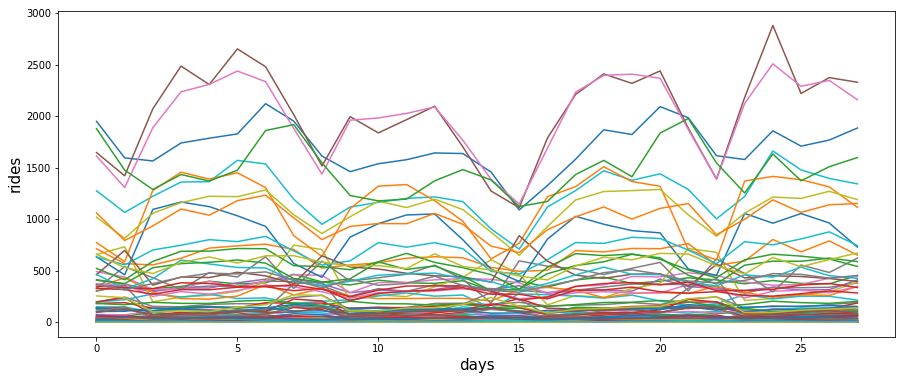

In [19]:
plt.figure(figsize=(15,6))
for i in range(len(arr)):
    plt.plot(arr[i])
plt.xlabel('days', fontsize = 15)
plt.ylabel('rides', fontsize = 15)

In [20]:
nyshp = gp.read_file('taxi_zone/taxi_zones.shp')

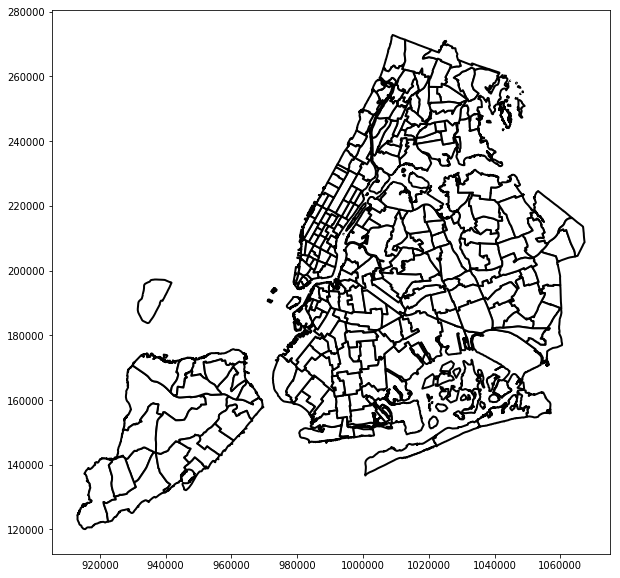

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
nyshp.plot(ax=ax, color="white", edgecolor="black", linewidth=1, lw=2)

In [22]:
nyshp.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [23]:
nyshp1 = nyshp.merge(df_drop_ID,left_on='LocationID',right_on='PULocationID',how='outer')

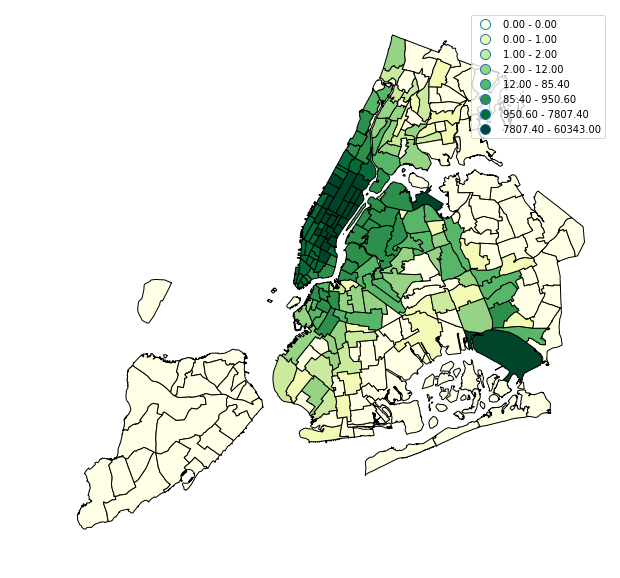

In [24]:
nyshp1['pick_count'] = nyshp1['pick_count'].fillna(0)
fig, ax = plt.subplots(figsize=(10,10))
nyshp1.plot(ax=ax, color='black', linewidth=1, alpha=0.1)
nyshp1.plot(ax=ax, column='pick_count', cmap='YlGn', edgecolor='black',scheme='Quantiles',k=10, legend=True);
ax.set_axis_off()
ax.legend()
#ax.set_title('asthma hospitalization rate',size=15)